# Neural Network

## Import and Settings

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump, load
import dask.dataframe as dd
import numpy as np

In [3]:
df = dd.read_csv('prepared_ds.csv')

## df_fast initialisieren (size = 0.01)

In [5]:
df_fast = df.sample(frac=0.01, random_state = 1).compute()

In [6]:
df_fast.shape

(75666, 41)

## train, test split

In [7]:
train, test, train_lbl, test_lbl = train_test_split(df_fast[df_fast.columns[1:-1]], df_fast['Label'], test_size=0.2, random_state=1)

## Training

In [8]:
clf1 = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(20, 10, 5), random_state=1, max_iter=1000)

In [9]:
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-8, hidden_layer_sizes=(20, 10, 5), random_state=1, max_iter=2000)

In [12]:
clfs = []
for clf_ in [(clf1, 'clf1'), (clf2, 'clf2')]:
    clf = clf_[0].fit(train, train_lbl)
    clfs.append((clf, clf_[1]))
    print(f'{clf_[1]} - accuracy={clf.score(test, test_lbl)}')
    for cv in [2, 'prefit']:
        for method in ['sigmoid', 'isotonic']:
          clf_calibrated = CalibratedClassifierCV(clf, cv=cv, method=method, n_jobs=-1)
          clf_calibrated.fit(train, train_lbl)
          clfs.append((clf_calibrated, f'{clf_[1]}-{cv}-{method}'))
          print(f'{clf_[1]} - cv={cv:20}, method={method:10s} - accuracy={clf_calibrated.score(test, test_lbl)}')
    print()

clf1 - accuracy=0.9975551737808908
clf1 - cv=                   2, method=sigmoid    - accuracy=0.996564028016387
clf1 - cv=                   2, method=isotonic   - accuracy=0.9969604863221885
clf1 - cv=prefit              , method=sigmoid    - accuracy=0.9975551737808908
clf1 - cv=prefit              , method=isotonic   - accuracy=0.9975551737808908

clf2 - accuracy=0.9974890973965904
clf2 - cv=                   2, method=sigmoid    - accuracy=0.99735694462799
clf2 - cv=                   2, method=isotonic   - accuracy=0.9969604863221885
clf2 - cv=prefit              , method=sigmoid    - accuracy=0.9974890973965904
clf2 - cv=prefit              , method=isotonic   - accuracy=0.99735694462799



## confusion matrix (fp (wenn 1 (positiv) = DDoS) minimieren)

In [18]:
if (clfs == []):
    clf = load('models/neural_network.joblib')
else:
    clf = clfs[0][0]

In [19]:
confusion_mtx = confusion_matrix(test_lbl, clf.predict(test))

In [20]:
np.round(confusion_mtx/len(test_lbl), 3)

array([[0.827, 0.002],
       [0.001, 0.171]])

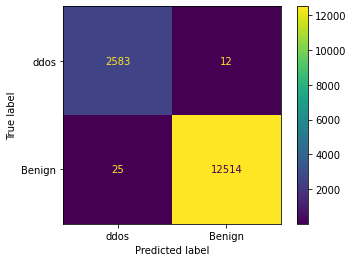

In [21]:
plot_confusion_matrix(clf, test, test_lbl, labels=['ddos', 'Benign'])

In [22]:
# false positive
confusion_mtx[0,1]

25

## Modell speichern

In [23]:
clf.get_params()

{'activation': 'relu',
 'alpha': 1e-07,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (20, 10, 5),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [24]:
dump(clf, 'models/neural_network.joblib')

['models/neural_network.joblib']